# Machine Learning

In this problem, we will implement both hard margin and soft margin SVMs practically.

## Package requirements

Some packages that are required but might not be installed in your enviroment. Uncomment any line that you don't have its corresponding package.

In [1]:
!pip install imageio
!pip install future

You should consider upgrading via the 'c:\users\mohammad\.conda\envs\cs231n\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\mohammad\.conda\envs\cs231n\python.exe -m pip install --upgrade pip' command.


## Import packages and configurations

In [2]:
from __future__ import print_function
import os
import pdb
import time
import math
import random
import numpy as np
from builtins import range
from imageio import imread
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots

# The following two lines let us reload external modules in the notebook
%load_ext autoreload
%autoreload 2

## Load dataset
We have provided the code for loading CIFAR-10 dataset for you. You only need to download CIFAR-10 dataset and extract in the `./cifar10` folder.

In [3]:
from utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar10/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualization

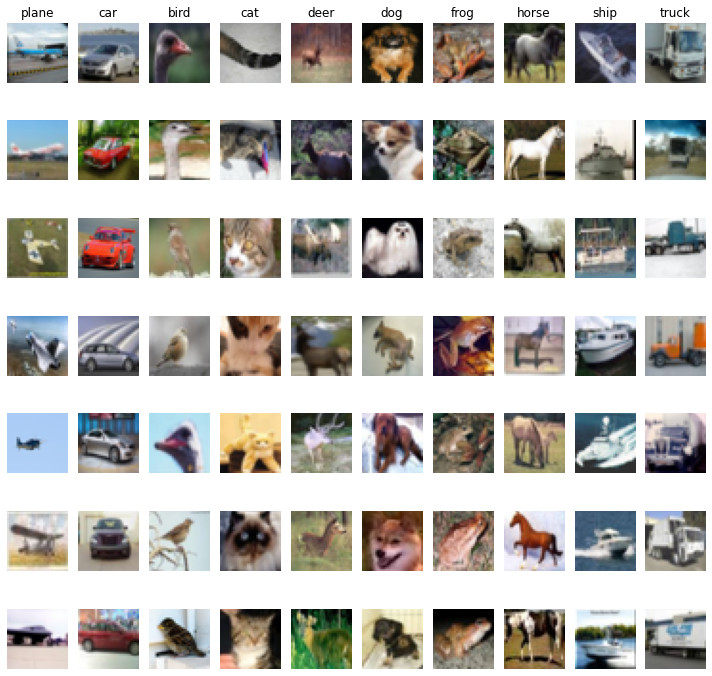

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.tight_layout()
plt.show()

## Dataset split and preprocessing

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


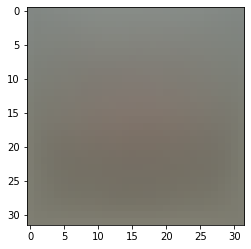

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Linear Multi-Class SVM with Hard-Margin

The loss function for a SVM loss is given by:

\begin{equation}
\large
L_i = \sum_{j\neq y^{(i)}} \max(0, w_j^T x^{(i)} - w_{y^{(i)}}^T x^{(i)} + 1)
\end{equation} 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from naive_svm import svm_loss_naive

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.126351


In [9]:
grad

array([[-13.1416222 ,   5.61482363,   3.57117637, ...,   4.6938102 ,
        -24.19321576, -57.20598747],
       [-27.65224653,   4.30608225,   3.55191776, ...,   1.78582653,
        -36.05138816, -55.47904102],
       [-50.16549616,  -0.1680267 ,  13.94602669, ...,   3.21060816,
        -55.3819822 , -63.77277477],
       ...,
       [  0.88925192,  -2.87226335,  10.00626335, ...,  -5.50819592,
          7.6095089 , -11.31163739],
       [ -7.21235886, -11.97155114,  13.02955114, ...,   8.27604286,
        -14.82763257, -16.40073057],
       [  0.096     ,   0.114     ,  -0.114     , ...,   0.1       ,
         -0.076     ,   0.162     ]])

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -1.342157 analytic: -1.342157, relative error: 6.253174e-11
numerical: 16.700713 analytic: 16.700713, relative error: 1.018288e-11
numerical: 7.807924 analytic: 7.807924, relative error: 1.611301e-11
numerical: -5.161978 analytic: -5.161978, relative error: 3.289802e-11
numerical: -46.171856 analytic: -46.171856, relative error: 2.610913e-12
numerical: 5.463146 analytic: 5.463146, relative error: 1.026475e-11
numerical: 4.216935 analytic: 4.216935, relative error: 3.178673e-11
numerical: -21.656868 analytic: -21.656868, relative error: 1.914568e-11
numerical: 6.780056 analytic: 6.780056, relative error: 1.203812e-12
numerical: 14.702656 analytic: 14.702656, relative error: 1.786342e-11
numerical: 15.611086 analytic: 15.611086, relative error: 3.885815e-11
numerical: 11.245037 analytic: 11.245037, relative error: 3.924511e-11
numerical: -10.932104 analytic: -10.932104, relative error: 2.832476e-11
numerical: -18.597946 analytic: -18.597946, relative error: 4.116636e-13
numeri

### Inline Question:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? Hint: the SVM loss function is not strictly speaking differentiable

<i>Yes, the svm loss function is not differentiable at some points and this is the reason we see some mismatches in gradcheck. However because loss function is differentiable everywhere except a few points this is not a reason for concern. <br /> For example in 1D imagine the function max(0, x); this function is clearly not differentiable at 0. But this is no problem in case of optimization because whether left or right derivatives are considered, we will still go towards minimum of the function. Changing the margin doesn't affect the number of undifferentiable points.</i>

In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from naive_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.126351e+00 computed in 0.168500s
Vectorized loss: 9.126351e+00 computed in 0.003981s
difference: -0.000000


In [13]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.208506s
Vectorized loss and gradient: computed in 0.003998s
difference: 0.000000


## Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `linear_classifier.py`.

In [14]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from linear_classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 785.957589
iteration 100 / 1500: loss 287.549255
iteration 200 / 1500: loss 107.499996
iteration 300 / 1500: loss 42.844585
iteration 400 / 1500: loss 18.923240
iteration 500 / 1500: loss 9.879367
iteration 600 / 1500: loss 7.216268
iteration 700 / 1500: loss 6.108232
iteration 800 / 1500: loss 5.020487
iteration 900 / 1500: loss 5.891393
iteration 1000 / 1500: loss 6.017319
iteration 1100 / 1500: loss 5.618165
iteration 1200 / 1500: loss 5.209627
iteration 1300 / 1500: loss 5.649455
iteration 1400 / 1500: loss 5.242347
That took 5.817091s


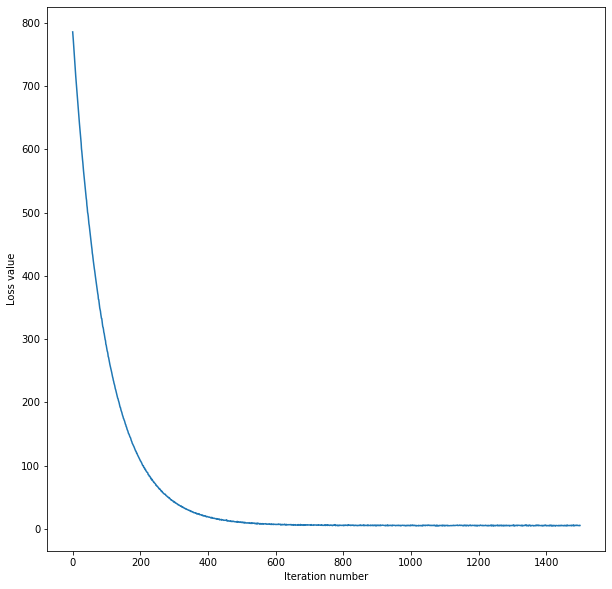

In [16]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [17]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370306
validation accuracy: 0.386000


In [18]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# hyperparamters values to do grid search over
learning_rates = [1e-8, 2e-7, 1e-7, 3e-5] #, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1e1, 3e1, 5e1]
regularization_strengths = [0.5e4, 1e4, 2e4, 2.5e4, 3e4, 3.5e4, 4e4]#, 4.5e4, 5e4, 5.5e4, 6e4]

# permute over learning_rates and regularization_strengths
grid_search = [(lr, reg) for lr in learning_rates \
               for reg in regularization_strengths]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for hp in grid_search:
    svm = LinearSVM()
    print('Training: ', hp)
    loss_hist = svm.train(X_train, y_train, learning_rate=hp[0], reg=hp[1],
                          num_iters=1500, verbose=False)
    y_train_pred = svm.predict(X_train)
    y_val_pred = svm.predict(X_val)
    train_acc = np.mean(y_train == y_train_pred)
    val_acc = np.mean(y_val == y_val_pred)
    results[hp] = (train_acc, val_acc)
    if val_acc > best_val:
        best_val = val_acc
        best_svm = svm    
    

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


Training:  (1e-08, 5000.0)
Training:  (1e-08, 10000.0)
Training:  (1e-08, 20000.0)
Training:  (1e-08, 25000.0)
Training:  (1e-08, 30000.0)
Training:  (1e-08, 35000.0)
Training:  (1e-08, 40000.0)
Training:  (2e-07, 5000.0)
Training:  (2e-07, 10000.0)
Training:  (2e-07, 20000.0)
Training:  (2e-07, 25000.0)
Training:  (2e-07, 30000.0)
Training:  (2e-07, 35000.0)
Training:  (2e-07, 40000.0)
Training:  (1e-07, 5000.0)
Training:  (1e-07, 10000.0)
Training:  (1e-07, 20000.0)
Training:  (1e-07, 25000.0)
Training:  (1e-07, 30000.0)
Training:  (1e-07, 35000.0)
Training:  (1e-07, 40000.0)
Training:  (3e-05, 5000.0)
Training:  (3e-05, 10000.0)
Training:  (3e-05, 20000.0)
Training:  (3e-05, 25000.0)
Training:  (3e-05, 30000.0)
Training:  (3e-05, 35000.0)
Training:  (3e-05, 40000.0)
lr 1.000000e-08 reg 5.000000e+03 train accuracy: 0.217490 val accuracy: 0.207000
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.231980 val accuracy: 0.258000
lr 1.000000e-08 reg 2.000000e+04 train accuracy: 0.239816 

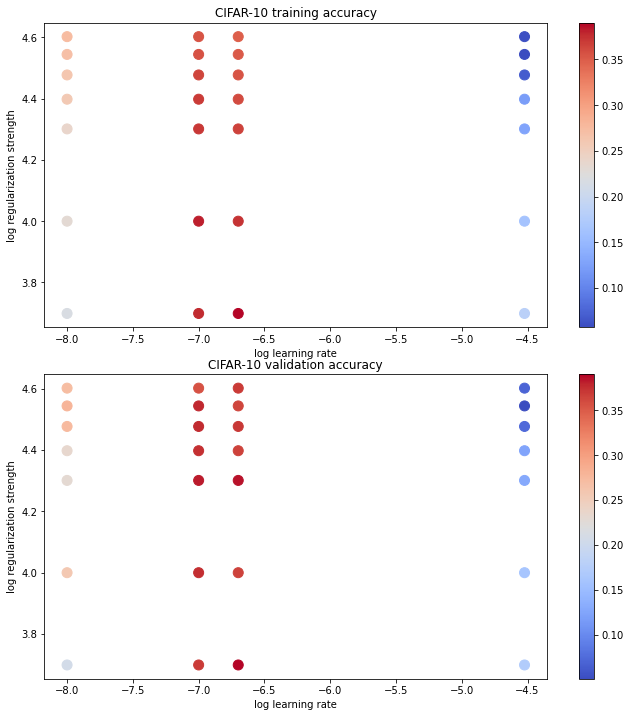

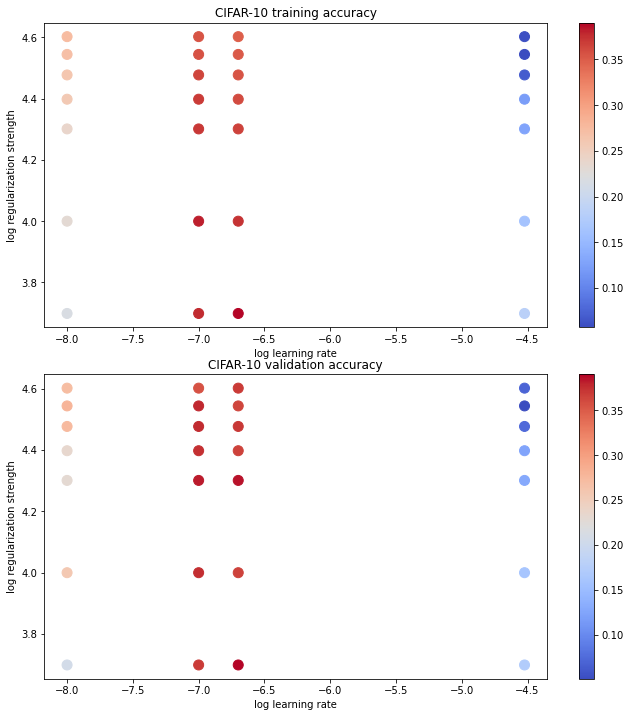

In [19]:
# Visualize the cross-validation results


# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()# Visualize the cross-validation results

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [20]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.377000


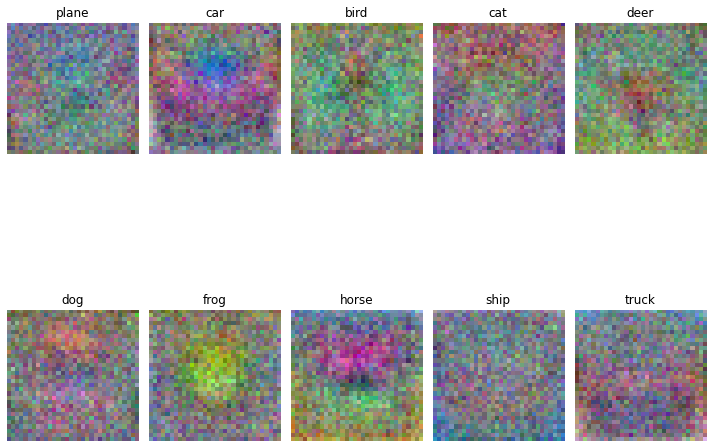

In [21]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.tight_layout()

### Inline Question

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

<i>Your Answer: The shape of SVM weights for each class tries to match the shape of objects in that class. Because then that template can detect patterns for each class and give a higher score to images of desired class and low score to images of other classes. For example if you look at the template shape for car, you can see some kind of car faced towards you. In fact because the weights try to capture all different kinds of a class (for instance in the case of car, some cars might be faced to different directions) the resulting template shape is a combination of all different kinds of that class.</i>

## Linear Multi-Class SVM with Soft-Margin

Multiclass SVM aims to assign labels to instances by using support-vector machines, where the labels are drawn from a finite set of several elements.

There are several ways to define a loss function for multi-class SVM. In this problem, the following loss function will be used for training the multi-class SVM (Please take a look at p. 46 of the ML Review slides):

\begin{equation}
\large
J(W) = \frac{1}{N} \sum_{i=1}^{N}{L^{(i)}} + \lambda ||W||^2\\
\large
L^{(i)} = \sum_{j \neq y^{(i)}}^{}{max(0, 1 + s_j - s_{y^{(i)}})} = \sum_{j \neq y^{(i)}}^{}{max(0, 1 + w_j^T x^{(i)} - w_{y^{(i)}}^T x^{(i)})}
\;\\
\end{equation} 

Open `svm.py` and complete the code of the linear svm model in it. Let's check your implementations first.

Let's first check if your model computes the hinge loss correctly. You should witness a small values as the error:

In [42]:
from svm import SVM

In [46]:
np.random.seed(42)
toy_model = SVM(n_features=10, n_classes=5, std=0.01)
x = np.random.rand(20, 10)
y = np.random.randint(0, 5, 20)
correct_loss = 3.999079560852596
loss = toy_model.loss(x, y, 0.25)

print('relative error of loss:', abs(loss - correct_loss))

relative error of loss: 0.007265668557264959


Now let's check if the gradients are computed correctly. You should get a small value as the error. Ours is of the order of 1e-8.

In [34]:
# >>>>>WARNING: RUN THIS CELL ONLY ONCE AFTER YOU RAN THE ABOVE CELL!<<<<<

gradient = toy_model.update_weights(learning_rate=1e-2)
correct_gradient = [[-0.24790043, -0.02616584,  0.0862217,  -0.066655,    0.25564707],
                    [-0.02056357,  0.05417903, -0.05449371, -0.07649293,  0.09846397],
                    [-0.01443777, -0.14332005, -0.00198323, -0.23687162,  0.39444998],
                    [-0.09852023,  0.03344655,  0.00652346, -0.15866452,  0.21542415],
                    [-0.2999338,  -0.04307378,  0.34938565, -0.32666563,  0.3199567 ],
                    [-0.1263978,   0.13268628,  0.15897914, -0.16465115, -0.00139483],
                    [-0.00084713, -0.17737171,  0.05615944,  0.03299787,  0.08956249],
                    [-0.1513251,  -0.05118482,  0.16787481, -0.12316938,  0.155753  ],
                    [-0.13682534,  0.14630157,  0.02634592, -0.10531288,  0.06899802],
                    [-0.13455525, -0.04130863,  0.11486015, -0.06620673,  0.12643906]]

assert gradient.shape == toy_model.W.shape
print('relative error of gradient:', np.linalg.norm(gradient - correct_gradient))

relative error of gradient: 0.03027301642455827


Let's train the model on the dataset:

In [27]:
model = SVM(n_features=3073, n_classes=10, std=0.001)

In [29]:
loss_history, train_history, val_history = model.train(X_train, y_train, X_val, y_val, 1000, 200)

iteration 0, loss 786.91463, train acc 10.88%, val acc 10.00%
iteration 100, loss 286.89888, train acc 20.83%, val acc 20.40%
iteration 200, loss 107.75943, train acc 27.74%, val acc 27.70%
iteration 300, loss 42.58361, train acc 32.16%, val acc 32.60%
iteration 400, loss 19.16809, train acc 34.94%, val acc 36.10%
iteration 500, loss 10.02158, train acc 36.30%, val acc 36.40%
iteration 600, loss 6.73790, train acc 36.93%, val acc 38.00%
iteration 700, loss 5.60139, train acc 36.18%, val acc 36.30%
iteration 800, loss 5.46268, train acc 37.01%, val acc 36.80%
iteration 900, loss 5.74408, train acc 36.42%, val acc 37.30%


Let's plot the training loss:

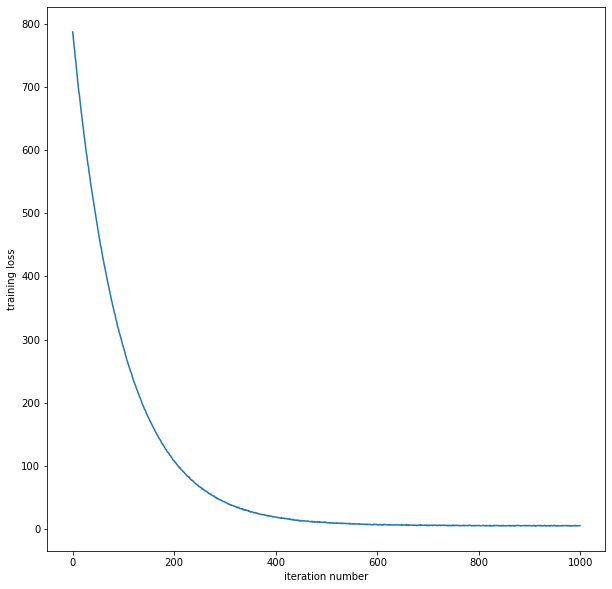

In [30]:
plt.plot(loss_history)
plt.ylabel('training loss')
plt.xlabel('iteration number')
plt.show()

Next, Let's plot the train_acc and test_acc.

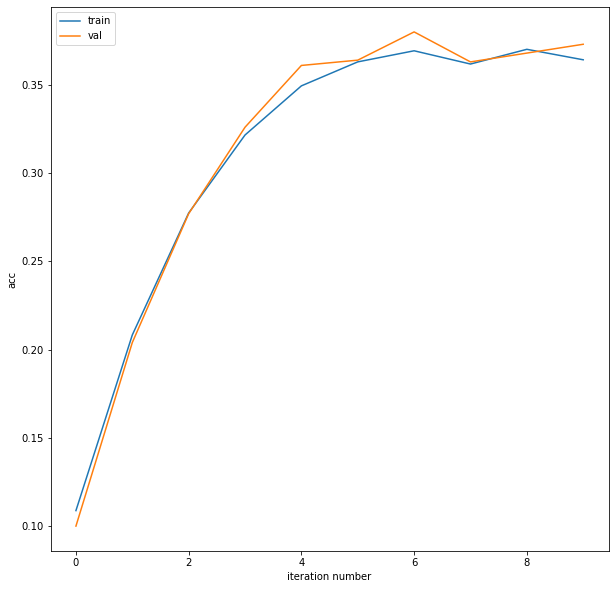

In [31]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.ylabel('acc')
plt.xlabel('iteration number')
plt.legend(loc="upper left")
plt.show()

Finally let's test your model on the test set.

In [32]:
predictions =  model.predict(X_test)
test_res = predictions == y_test
test_acc = np.sum(test_res) / len(test_res)
print("accuracy on test set: %.2f%%" % (100*test_acc))

accuracy on test set: 37.20%
